# Music Genre Classification 
### by @fcacharelli and @mdtc

In [1]:
#install Speech lib

#import pip

#package_names=['python_speech_features'] #packages to install
#pip.main(['install'] + package_names + ['--upgrade']) # --upgrade to install or update existing packages

#pip install python_speech_features #in case of not having it installed 

## 1. Import Libraries

In [1]:
# Import libraries 

from python_speech_features import mfcc
import scipy.io.wavfile as wav
import numpy as np
from tempfile import TemporaryFile
import os
import pickle
import random 
import operator
import math
import numpy as np

In [2]:
import pandas as pd

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Load DataSet

In [5]:
Genres = {
    1: "Blues",
    2: "Classical",
    3: "Country",
    4: "Disco",
    5: "Hip Hop",
    6: "Jazz",
    7: "Metal",
    8: "Pop",
    9: "Reggae",
    10: "Rock"
}

In [6]:
# Prepare Dataset
# Practice only, use master branch's dataset.

directory = os.path.dirname(os.path.realpath("MLMusicGenre")) + "\\data"
f= open("mgenres.dat" ,'wb')
i=0
for folder in os.listdir(directory):
    i+=1
    if i==11 :
        break   
    for file in os.listdir(directory+"\\"+folder):  
        (rate,sig) = wav.read(directory+"\\"+folder+"\\"+file)
        mfcc_feat = mfcc(sig,rate ,winlen=0.020, appendEnergy = False)
        covariance = np.cov(np.matrix.transpose(mfcc_feat))
        mean_matrix = mfcc_feat.mean(0)
        feature = (mean_matrix , covariance , i)
        pickle.dump(feature , f)
f.close() 

In [8]:
# Load Dataset

def loadDataSet(fileName):
    with open(fileName, "rb") as f:
        while True:
            try:
                dataset.append(pickle.load(f))
            except EOFError:
                f.close()
                break
    
dataset=[]
loadDataSet("genres.dat")

In [9]:
# Convert to Pandas Data Frame

dataset = pd.DataFrame(dataset)
dataset

,0,1,2
0,"[76.5026110677372, -1.9614173589380144, -15.77...","[[31.364326631614066, -1.3468342058680451, -0....",1
1,"[66.93164964522649, 0.7188534538996809, -3.267...","[[107.79187315415385, -31.411100328803215, -9....",1
2,"[78.7741031258866, 3.039700087120104, -19.0244...","[[41.929518828588385, -21.58695775545638, -30....",1
3,"[66.69610667522518, 9.211514465758532, -4.5328...","[[70.07832382282082, -31.52905508596631, 2.620...",1
4,"[71.97284566377586, 0.5064100190354653, -23.83...","[[73.97934723712848, -49.0136740941537, -34.35...",1
...,...,...,...
995,"[73.39782483055345, -4.459683299978229, -14.65...","[[21.58115076126584, -17.780006213473275, -4.3...",10
996,"[73.96549448871167, -4.293810209685265, -18.14...","[[36.05839587905572, -21.80388797679555, -7.00...",10
997,"[75.55902537392254, -5.658250351745185, -24.03...","[[18.18242292339917, -15.896549001368685, -7.1...",10
998,"[65.61635032690315, 2.2903386914587833, -10.02...","[[122.2511166206538, -35.56627502776603, -71.1...",10


There are 1000 rows, each contains an array of 13 elements in column 0,
A 13x13 matrix in column 1 and Class identifier (1-10) in column 2.
We will try to use the 13 elements array as a genre predictor.

In [31]:
# Target Class (genres)

genres = dataset[2]
genres

0       1
1       1
2       1
3       1
4       1
       ..
995    10
996    10
997    10
998    10
999    10
Name: 2, Length: 1000, dtype: int64

In [25]:
# Deploy features in Data Frame (df)

column_names = ["F"+str(i) for i in range(0, 182)]

df = pd.DataFrame(columns = column_names)

for i in range(0,1000):
    array = []
    for j in range(0,13):
        array.append(dataset.iloc[i][0][j])
        for h in range(0,13):
            array.append(dataset.iloc[i][1][j][h])
    df=df.append(dict(zip(df.columns, array)), ignore_index=True)

In [26]:
df.head()

,F0,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F172,F173,F174,F175,F176,F177,F178,F179,F180,F181
0,76.502611,31.364327,-1.346834,-0.948272,-20.538228,-14.584781,-17.234794,-9.351457,2.720345,-3.290355,...,-6.849163,3.786696,-0.021175,-14.523117,-12.995331,-3.843489,-14.831619,2.251195,29.282607,64.650762
1,66.931650,107.791873,-31.411100,-9.226987,-58.260452,-26.472495,-32.545363,-49.984433,15.732432,-17.986251,...,3.409339,-16.026806,-13.013754,18.476615,11.603178,-3.788941,-17.738734,-8.665845,18.410328,90.762876
2,78.774103,41.929519,-21.586958,-30.464976,-18.578531,-6.408160,-1.864210,-11.321598,-1.374473,-9.150725,...,19.969703,-18.087720,-6.627783,-2.016122,-12.890326,-3.702126,-3.862404,0.221521,-9.624113,83.777252
3,66.696107,70.078324,-31.529055,2.620868,-8.306382,-40.028341,-15.373341,-19.554054,-13.988605,-10.777105,...,1.405610,-21.272778,-13.864303,13.764830,4.091590,-5.564044,-11.718776,-10.097750,4.902070,69.758813
4,71.972846,73.979347,-49.013674,-34.352215,25.587893,-34.990130,30.040339,26.715988,19.962725,-28.027692,...,-13.499979,-15.531564,9.558282,14.068872,-4.271712,-29.419962,13.653176,6.385477,7.264809,102.319498


## 3. Standardize Scale

In [32]:
# Create an instance of the StandardScaler

scaler = StandardScaler()

In [33]:
# Fit the Scaler to the data, except the Target Class

scaler.fit(df)

StandardScaler()

In [34]:
# Actually transform the data into an array

scaled_features = scaler.transform(df)

In [35]:
# Cast array to DataFrame

df_feat = pd.DataFrame(scaled_features, columns=df.columns[:])

In [36]:
df_feat

,F0,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F172,F173,F174,F175,F176,F177,F178,F179,F180,F181
0,0.270973,-0.127847,0.722965,0.656796,-0.615857,-0.148250,-0.564720,-0.408985,0.102941,-0.109106,...,-0.739966,0.135703,0.295860,-0.785628,-0.762488,-0.140165,-0.608138,0.337143,0.282861,-0.614068
1,-0.714168,0.261696,-0.482031,0.414503,-2.652460,-0.786573,-1.329539,-2.900857,0.894233,-1.019298,...,-0.052732,-1.241419,-0.489888,1.264134,0.629181,-0.137173,-0.771948,-0.214311,-0.359266,0.209481
2,0.504779,-0.073998,-0.088273,-0.207069,-0.510054,0.290802,0.203097,-0.529806,-0.146074,-0.472069,...,1.056673,-1.384661,-0.103685,-0.008762,-0.756548,-0.132411,0.009954,0.234618,-2.015009,-0.010838
3,-0.738413,0.069474,-0.486758,0.761254,0.044534,-1.514468,-0.471734,-1.034673,-0.913166,-0.572799,...,-0.186965,-1.606036,-0.541326,0.971464,0.204211,-0.234535,-0.432736,-0.286641,-1.157078,-0.452965
4,-0.195277,0.089357,-1.187554,-0.320837,1.874467,-1.243936,1.796846,1.802900,1.151487,-1.641215,...,-1.185515,-1.206998,0.875194,0.990349,-0.268946,-1.543012,0.996920,0.545979,-1.017532,0.573965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.048603,-0.177711,0.064313,0.556490,-0.169722,0.229966,0.182351,-0.164457,-0.318256,-0.273025,...,-0.164699,-0.726277,-0.534927,-0.412745,-0.260562,-0.554906,-0.996470,0.035648,1.048687,0.212329
996,0.009827,-0.103922,-0.096967,0.479393,-0.192720,0.123183,-0.203838,-0.300958,-0.983380,-0.276451,...,-0.124281,-0.113861,0.070178,0.109582,0.075008,0.083156,0.068300,0.407974,-0.608246,-1.241892
997,0.173850,-0.195034,0.139803,0.476668,-0.313193,0.437053,0.277001,0.349994,0.383720,-0.197373,...,1.389437,-0.237918,0.699850,-0.198866,-0.321658,0.477405,-0.747616,-0.160213,-0.265182,-0.410179
998,-0.849552,0.335393,-0.648573,-1.396481,-1.082275,1.561251,2.224351,1.056659,0.521143,0.963748,...,0.400214,-0.059095,-0.031555,-0.103718,0.341030,0.431600,0.262041,-0.135034,-0.148325,-0.381238


## 4.  Split data

In [37]:
# Use train_test_split to split randomly, having 30% of the data for testing.

X = df_feat
y = genres

X_train,  X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

## 5. Apply KNN Model

In [38]:
# Instance of the classifier with k=1

knn = KNeighborsClassifier(n_neighbors=1)

In [39]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [40]:
# Calculate predictions

pred = knn.predict(X_test)

## 6. Evaluate

In [41]:
# Confusion Matrix and Classification Report

print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))

[[17  0  2  1  1  0  0  0  0  3]
 [ 0 36  0  1  0  2  0  0  1  0]
 [ 1  1 12  5  0  1  0  3  0  5]
 [ 1  0  0 12  0  1  6  1  0  8]
 [ 1  0  2  1 17  0  2  5  0  2]
 [ 1  2  0  1  0 19  1  0  0  0]
 [ 1  1  0  1  0  0 25  0  0  4]
 [ 0  0  2  0  0  0  0 19  2  3]
 [ 2  0  2  7  5  0  0  1 19  1]
 [ 1  2  1  4  2  1  2  2  0 15]]
              precision    recall  f1-score   support

           1       0.68      0.71      0.69        24
           2       0.86      0.90      0.88        40
           3       0.57      0.43      0.49        28
           4       0.36      0.41      0.39        29
           5       0.68      0.57      0.62        30
           6       0.79      0.79      0.79        24
           7       0.69      0.78      0.74        32
           8       0.61      0.73      0.67        26
           9       0.86      0.51      0.64        37
          10       0.37      0.50      0.42        30

    accuracy                           0.64       300
   macro avg       

##  7. Optimize

In [42]:
# Iterate the model for different k values and calculate Error Rates 
error_rate = []

for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    prediction = knn.predict(X_test)
    error_rate.append(np.mean(prediction!=y_test)) # Mean of boolean array, 1: mistake, 0: right

Text(0, 0.5, 'Error Rate')

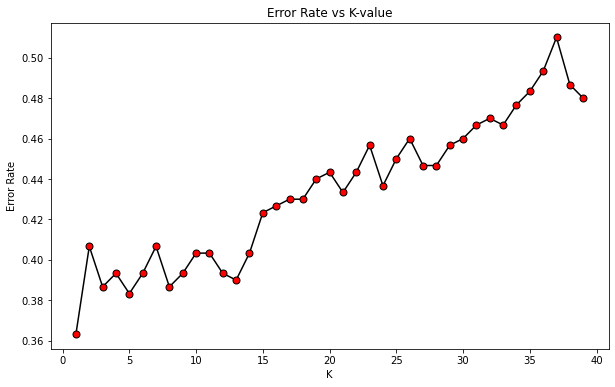

In [43]:
# Plot error rates to optimize k value

plt.figure(figsize=(10,6))
plt.plot(range(1,40), 
         error_rate, 
         color="black", 
         linestyle="-", 
         marker="o", 
         markerfacecolor="red", 
         markersize=7)
plt.title("Error Rate vs K-value")
plt.xlabel("K")
plt.ylabel("Error Rate")

## 8. Choose K-value
We will use k=33

In [46]:
knn = KNeighborsClassifier(n_neighbors=14)
knn.fit(X_train,y_train)
pred = knn.predict(X_test)

print(confusion_matrix(y_test,pred))
print("\n")
print(classification_report(y_test,pred))

[[15  0  2  0  0  1  3  0  0  3]
 [ 1 35  1  0  0  3  0  0  0  0]
 [ 0  1 15  3  0  1  2  3  0  3]
 [ 0  0  0 11  0  0 11  1  0  6]
 [ 0  0  2  6 17  0  2  2  0  1]
 [ 1  6  1  0  1 11  4  0  0  0]
 [ 0  0  1  1  0  0 30  0  0  0]
 [ 0  0  0  1  0  1  0 23  1  0]
 [ 1  0  1 10 10  1  1  0 11  2]
 [ 0  2  0  6  3  0  7  1  0 11]]


              precision    recall  f1-score   support

           1       0.83      0.62      0.71        24
           2       0.80      0.88      0.83        40
           3       0.65      0.54      0.59        28
           4       0.29      0.38      0.33        29
           5       0.55      0.57      0.56        30
           6       0.61      0.46      0.52        24
           7       0.50      0.94      0.65        32
           8       0.77      0.88      0.82        26
           9       0.92      0.30      0.45        37
          10       0.42      0.37      0.39        30

    accuracy                           0.60       300
   macro avg     

## 9. Test Model

In [133]:
(rate,sig)=wav.read("bob marley.wav")
mfcc_feat=mfcc(sig,rate,winlen=0.020,appendEnergy=False)
covariance = np.cov(np.matrix.transpose(mfcc_feat))
mean_matrix = mfcc_feat.mean(0)
feature=(mean_matrix,covariance,0)


In [135]:
knn = KNeighborsClassifier(n_neighbors=33)
knn.fit(X_train,y_train)
pred = knn.predict() #Transpose
print(Genres[pred[0]])

Pop
